In [1]:
import meep as mp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
print(mp.__version__)

from numpy.fft import fft, ifft, fftfreq

1.16.1


[Finite-difference time-domain simulation of thermal noise in open cavities](https://doi.org/10.1103/PhysRevA.77.023810)
$$D_n (\omega,T) = \frac{6\hbar^2}{\pi k_B^2 T^2}\left(\frac{\omega}{\exp\frac{\hbar\omega}{k_B T}-1}\right)$$

When $\omega = 0$, the denominator is zero, which causes the numerical problem. The remedy is to use Taylor expansion as $x\ll 1$.

$$\frac{1}{\exp{x}-1} = 1 - \frac{x}{2} + \frac{x^2}{12}-\frac{x^4}{720}+O(x^6)$$


/home/jwu/qno/envs/mp/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


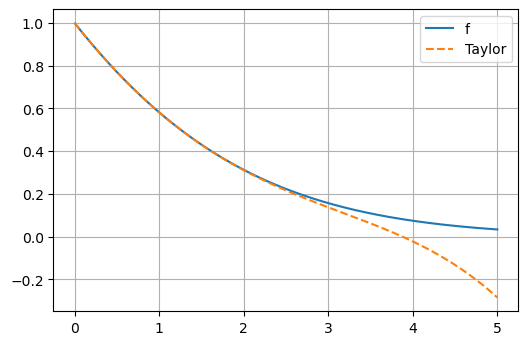

In [2]:
## Test the equation
Nx = 1000
x = np.linspace(0,5,Nx)
tmp = np.exp(x) -1
f1 = x /tmp ## there is a warning since tmp[0] = 0
f2 = 1 - x/2 + x **2/12 -x**4/720
##
fig = plt.figure(dpi=100)
plt.plot(x,f1,label='f')
plt.plot(x,f2,'--',label='Taylor')
plt.grid()
plt.legend()
plt.show()
                

In [3]:
##

resolution = 50                # pixels/um
dpml = 1.0                      # PML thickness
sz = 16 + 2*dpml
cell_size = mp.Vector3(z=sz)
pml_layers = [mp.PML(dpml)]

dimensions = 1
tsim = 1000
courant = 0.5 
dt = courant  / resolution
Nt = int(tsim/dt + 1)
tslice = np.linspace(0, tsim, Nt)

##
omegal = 2 * np.pi / Nt * np.linspace(0,Nt-1,Nt) 
ml = np.random.normal(0,1,Nt)
nl = np.random.normal(0,1,Nt)

We adopt Eq. (6) from [PHYSICAL REVIEW A 77, 023810 (2008)](https://doi.org/10.1103/PhysRevA.77.023810), but make some changes of the definitions. 
$$E_s(t) = \frac{\delta}{\sqrt{t_\mathrm{sim}}}\sum_{l=0}^{N_t-1} (M_l + i N_l)D_n(\omega_l,T)e^{i\omega_l t}$$

In [ ]:
##

def Dnsqr(omega,T):
    x = np.abs(omega/T)
    if x > 1e-3:
        tmp = omega / (np.exp(omega/T)-1) / T
        output = 6 /np.pi/T  * tmp
    else:
        output = 6 /np.pi/T * (1 - x/2 + x **2/12 -x**4/720) ## Taylor expansion
    
    output = np.sqrt(output)
    return output

tempe = 1
dlsqr = np.empty(Nt)

for i in range(Nt):
     dlsqr[i] = Dnsqr(omegal[i],tempe) 

fc = (ml + 1j * nl) * dlsqr ## Fourier component from Eq. 6        
    
## use fft to generate signal
ts1 = time.time()

  

Ef = ifft(fc)

te1 = time.time()

## use for loop to generate signal

Ef2 =np.empty(Nt) 

ts2 = time.time()

Ef2 = np.zeros(Nt,dtype=complex)

for i in range(Nt):
       Ef2[i] = sum( fc * np.exp(1j * omegal * i))/Nt

te2 = time.time()

In [ ]:
##
fig = plt.figure(dpi=100)
plt.plot(tslice,np.real(Ef),'b',label = 'FFT',linewidth=1.5)
plt.plot(tslice,np.real(Ef2),'g--', label = 'For loop',linewidth=1.5)
plt.xlim(0,1)
plt.ylim(-0.008,0.008)
plt.legend()
plt.grid()
plt.show()

print('using FFT', te1-ts1)
print('using for loop', te2-ts2)
print('ratio of computation time =', (te2-ts2)/(te1-ts1)) 
print('prediction by complexity: Nt /log2(Nt) =', Nt/np.log2(Nt)) 


0.0